In [1]:
import pandas as pd
import operator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, recall_score, roc_curve, confusion_matrix, log_loss

In [2]:
def tnr_score(true,pred):
    """
    Returns the true negative rate of a classifier
    
    Parameters
    ----------
    true : array
        the true class labels
    pred : array
        the predicted class labels
        
    Returns
    -------
    tnr : float
        true negative rate
    """
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    tnr = tn / (tn+fp)
    return tnr

***
# Data preparation
* Encode binary variables manually to preserve interpretation of slope coefficients
* One-hot encode all other categorical variables

In [3]:
df = pd.read_csv('GermanCreditScoring.csv')

df.credit_risk = df.credit_risk.map({category:i for category,i in zip(
    ['good','bad'],
    range(0,2))}
)
df.foreign_worker = df.foreign_worker.map({category:i for category,i in zip(
    ['yes','no'],
    range(0,2))}
)
df.telephone = df.telephone.map({category:i for category,i in zip(
    ['no','yes (under customer name)'],
    range(0,2))}
)
df.people_liable = df.people_liable.map({category:i for category,i in zip(
    ['3 or more','0 to 2'],
    range(0,2))}
)

df = pd.get_dummies(df) # One hot encode the remaining nominal categorical variables
df['intercept'] = np.ones(len(df))
df.head()

,duration,amount,age,people_liable,telephone,foreign_worker,credit_risk,status_... < 0 DM,status_... >= 200 DM / salary for at least 1 year,status_0<= ... < 200 DM,...,housing_rent,number_credits_1,number_credits_2-3,number_credits_4-5,number_credits_>= 6,job_manager/self-empl./highly qualif. employee,job_skilled employee/official,job_unemployed/unskilled - non-resident,job_unskilled - resident,intercept
0,18,1049,21,1,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1.0
1,9,2799,36,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1.0
2,12,841,23,1,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,1.0
3,12,2122,39,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1.0
4,12,2171,38,1,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,1.0


***
# Modelling
* Create a hold-out set

In [4]:
y = df.credit_risk.values
X = df.drop(columns='credit_risk').values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

def col_mask(subset):
    """
    Creates a boolean mask for the columns of X using their names
    
    Parameters
    ----------
    subset : list of strings
        the columns that make up the subset

    Returns
    -------
    mask : list of bools
    """
    mask = df.drop(columns='credit_risk').columns.isin(subset)
    
    return mask

### Functions for cross validation
* Stratified cross validation - each fold keeps the same ratio of classes; every fold represents the dataset more; estimation of performance is more general

In [5]:
kf = StratifiedKFold(n_splits=10)
        
class evaluate:
    """
    Fulfills the following goals through cross-validation:
        * Evaluate a set of classifier hyper-parameters in terms of AUC
        * Evaluate a subset of features in terms of AUC
        * Decide on a decision threshold for a classifier
        
    Parameters
    ----------
    clf : sklearn classifier object

    subset : list of bools (optional)
        the boolean mask to select a subset of features
    """
    def __init__(self,clf,**kwargs):
        subset = kwargs.get('subset', None)
        
        if subset is not None:
            self.subset = subset # Use this for filtering X_test in model_assessment function
            self.X_train_ = X_train[:,subset] # Filter the columns of the training data
        else:
            self.X_train_ = X_train
            
        self.clf = clf
        
        return
    
    def cv_auc(self):
        """
        Evaluates the clf across the folds in terms of AUC
        
        Returns
        -------
        res : list
            auc mean, auc se and the mean tree size (if clf is a tree)
        """
        X_train = self.X_train_
        clf = self.clf
        
        auc_scores = []

        if str(type(clf)).find("tree")>0:
            # If the classifier is a tree, we are interested in recording tree size
            tree = True
            tree_sizes = []
            
        else:
            tree = False

        for train_index, test_index in kf.split(X_train,y_train):
            X_tr, X_te = X_train[train_index], X_train[test_index]
            y_tr, y_te = y_train[train_index], y_train[test_index]
            clf.fit(X_tr,y_tr)
            
            # Record the AUC
            auc_scores.append(roc_auc_score(y_te,clf.predict_proba(X_te)[:,1]))

            if tree == True:
                # Record the tree size
                nodes = clf.tree_.children_left # Find 
                tree_sizes.append(len(nodes[nodes!=-1])) # What did this mean again?

        res = [np.mean(auc_scores), # AUC mean across folds
               np.std(auc_scores)/np.sqrt(len(auc_scores))] # SE of AUC mean

        if tree == True:
            res.append(np.mean(tree_sizes)) # Mean size across folds

        return res
    
    def cv_threshold(self):
        """
        Decides a threshold for each objective
        
        Returns
        -------
        res : list
            the parameters and their performance for both objectives
        """
        X_train = self.X_train_
        clf = self.clf
        
        threshold_results_obj1 = pd.DataFrame()
        threshold_results_obj2 = pd.DataFrame()
        
        for train_index, test_index in kf.split(X_train,y_train):
            X_tr, X_te = X_train[train_index], X_train[test_index]
            y_tr, y_te = y_train[train_index], y_train[test_index]
            clf.fit(X_tr,y_tr)
            
            probs = clf.predict_proba(X_te)[:,1]
            
            opt_threshold_obj1 = self.find_fold_threshold(probs,y_te,1)
            threshold_results_obj1 = threshold_results_obj1.append(opt_threshold_obj1)
            
            opt_threshold_obj2 = self.find_fold_threshold(probs,y_te,2)
            threshold_results_obj2 = threshold_results_obj2.append(opt_threshold_obj2)
        
        # Print results
        print('\nObjective 1 Results\n'+'-'*19+'\n')
        print(threshold_results_obj1.reset_index(drop=True))
        print('\n'+'-'*100+'\n')
        print('Objective 2 Results\n'+'-'*19+'\n')
        print(threshold_results_obj2.reset_index(drop=True))
        
        return threshold_results_obj1.threshold.mean(),threshold_results_obj2.threshold.mean()

    def find_fold_threshold(self,probs,test,obj):
        """
        Finds the optimal decision threshold for given an objective and a set of data
        Used on each fold of the cross validation
        
        If the p >= threshold classify positive

        For objective 1 (85+% TNR)
        * Start with a threshold of 1 and iterate through to a threshold of 0
        * Cancel iteratiion when the objective is no longer satisfied
        * Within the set of thresholds which satisfy the objective, select the one with the maximum TPR

        For objective 2 (98+% TPR)
        * Start with a threshold of 0 and iterate through to a threshold of 1
        * Cancel iteratiion when the objective is no longer satisfied
        * Within the set of thresholds which satisfy the objective, select the one with the maximum TNR

        Parameters
        ----------
        probs : list
            probabilities for the test set

        test : list
            classes for the test set

        obj : int, {1, 2}
            the objective to achieve

        Returns
        -------
        A DataFrame of the optimal threshold and the TPR / TNR for that threshold on the test set
        """    
        tnrs = []
        thresholds = []
        recalls = []

        for p in np.arange(0,1.005,0.005):
            _ = probs.copy()
            if obj==1:
                p=1-p # This allows us to search from 1 to 0
            
            # Turn _ into a vector of classes
            _[_>=p] = 1 # Classify positive
            _[_!=1] = 0 # Classify negative
            
            # Calculate metrics based on the predicted classes and the actual classes
            recall = recall_score(test,_)
            tnr = tnr_score(test,_)
            
            if obj==1:
                if tnr >= 0.85:
                    tnrs.append(tnr)
                    thresholds.append(p)
                    recalls.append(recall)
                else:
                    # End iteration
                    _ = pd.DataFrame({'tpr':recalls,'tnr':tnrs,'threshold':thresholds})
                    assert len(_) > 0 # Check that atleast one threshold achieved the objective

                    return _.loc[_.tpr.idxmax()]

            if obj==2:
                if recall >= 0.98:
                    tnrs.append(tnr)
                    thresholds.append(p)
                    recalls.append(recall)
                else:
                    # End iteration
                    _ = pd.DataFrame({'tpr':recalls,'tnr':tnrs,'threshold':thresholds})
                    assert len(_) > 0 # Check that atleast one threshold achieved the objective
                    
                    return _.loc[_.tnr.idxmax()]
                
    def model_assessment(self,obj1_threshold,obj2_threshold):
        """
        Performs the final assessment of the model on the hold-out set
        
        Parameters
        ----------
        obj1_threshold : float
            the threshold to use for objective 1 (85+% TNR)
        
        obj2_threshold : float
            the threshold to use for objective 2 (98+% TPR)
            
        Returns
        -------
        clf : sklearn classifier object
            the fitted classifier for further analysis (tree size etc.)
        """
        clf = self.clf

        clf.fit(self.X_train_,y_train)
        
        try:
            probs = clf.predict_proba(X_test[:,self.subset])[:,1]
            
        except:
            probs = clf.predict_proba(X_test)[:,1]
        
        obj1_labels = [1 if p>=obj1_threshold else 0 for p in probs]
        print('\nObjective 1 out-of-sample performance\n'+'-'*37+'\n')
        print(f'TPR: {recall_score(y_test,obj1_labels)}')
        print(f'TNR: {tnr_score(y_test,obj1_labels)}')
        
        print('\n'+'-'*100)
        
        obj2_labels = [1 if p>=obj2_threshold else 0 for p in probs]
        print('\nObjective 2 out-of-sample performance\n'+'-'*37+'\n')
        print(f'TPR: {recall_score(y_test,obj2_labels)}')
        print(f'TNR: {tnr_score(y_test,obj2_labels)}')

        return probs, clf

***
# Decision Tree
* Perform a grid search on the DecisionTreeClassifier adjusting the ccp_alpha, criterion and min_samples_split parameters

In [6]:
def DT_param_search(param_grid):
    """
    Finds the optimal parameters for the DecisionTreeClassifier
    
    Parameters
    ----------
    param_grid : dict
    
    Returns
    -------
    best_model : dict
        the optimal parameters
    """
    auc_mean = []
    auc_se = []
    s = []

    for params in list(ParameterGrid(param_grid)):
        # For each combination of parameters perform a cross validation
        # Obtain mean mcr, se of mcr mean and mean size
        auc_mean_i, auc_se_i, s_i = evaluate(DecisionTreeClassifier(**params)).cv_auc()
        auc_mean.append(auc_mean_i)
        auc_se.append(auc_se_i)
        s.append(s_i)

    # Collate results into a DataFrame
    res = pd.DataFrame({'size':s,'auc':auc_mean,'se':auc_se,'params':list(ParameterGrid(param_grid))})
    # Split params column into three separate columns
    res[['ccp_alpha','criterion','min_samples_split']] = res['params'].apply(pd.Series)
    res.fillna("None",inplace=True)

    # Compare results for some of the parameters for interest
    print('\nResults\n'+'-'*7+'\n')
    print("Gini AUC mean: {:.2f}".format(res.loc[res.criterion=="gini",'auc'].mean()))
    print("Entropy AUC mean: {:.2f}".format(res.loc[res.criterion=="entropy",'auc'].mean()))
    print("Gini leaf size mean: {:.2f}".format(res.loc[res.criterion=="gini",'size'].mean()))
    print("Entropy leaf size mean: {:.2f}".format(res.loc[res.criterion=="entropy",'size'].mean()))
    print(res.groupby('min_samples_split').agg({'size':'mean'}))

    # Find the parameters of simplest model who's mean AUC is within 1 SE of the highest recorded AUC
    # and whose tree size is greater than 5 (not too simple)
    candidate_models = res.loc[(res['size']>5)&(res.auc+res.se>=max(res.auc))]
    best_model = candidate_models.loc[candidate_models['size'].idxmin()]
    print("\n"+"-"*100)
    print('\nBest Model\n'+'-'*10+'\n')
    print(best_model)

    return best_model['params']

In [7]:
final_tree_params = DT_param_search(param_grid={'ccp_alpha': np.linspace(0.0,0.01,25),
                                                'criterion': ['gini', 'entropy'],
                                                'min_samples_split':np.linspace(0.01,0.1,10)})


Results
-------

Gini AUC mean: 0.68
Entropy AUC mean: 0.65
Gini leaf size mean: 16.22
Entropy leaf size mean: 30.32
                     size
min_samples_split        
0.01               46.004
0.02               34.722
0.03               28.476
0.04               24.652
0.05               21.116
0.06               18.526
0.07               16.706
0.08               15.292
0.09               14.098
0.10               13.088

----------------------------------------------------------------------------------------------------

Best Model
----------

size                                                               6.6
auc                                                            0.69215
se                                                            0.018868
params               {'ccp_alpha': 0.00625, 'criterion': 'gini', 'm...
ccp_alpha                                                      0.00625
criterion                                                         gini
min_samples_split 

In [8]:
print(final_tree_params)

{'ccp_alpha': 0.00625, 'criterion': 'gini', 'min_samples_split': 0.1}


### Threshold

Decide on a probability threshold for each objective

In [9]:
tree_threshold_obj1, tree_threshold_obj2 = evaluate(DecisionTreeClassifier(**final_tree_params)).cv_threshold()


Objective 1 Results
-------------------

   threshold       tnr       tpr
0      0.640  0.875000  0.250000
1      0.650  0.910714  0.208333
2      0.420  0.875000  0.458333
3      0.690  0.875000  0.458333
4      0.540  0.875000  0.500000
5      0.675  0.946429  0.208333
6      0.775  0.964286  0.208333
7      0.725  1.000000  0.041667
8      0.650  0.857143  0.250000
9      0.490  0.892857  0.208333

----------------------------------------------------------------------------------------------------

Objective 2 Results
-------------------

   threshold       tnr  tpr
0      0.000  0.000000  1.0
1      0.000  0.000000  1.0
2      0.005  0.017857  1.0
3      0.000  0.000000  1.0
4      0.000  0.000000  1.0
5      0.000  0.000000  1.0
6      0.000  0.000000  1.0
7      0.000  0.000000  1.0
8      0.000  0.000000  1.0
9      0.000  0.000000  1.0


***
# Logistic Regression

In [10]:
clf_lr = LogisticRegression(penalty='none',fit_intercept=False,max_iter=2000)

This subset selection method can be criticised. Variables are selected based on the whole training set, then a subset is chosen from the stages based on AUC across the cross-validation. In this sense, the model sees the training data twice, which is data leakage, this is discussed in ESL (p.245). However, this is how the course taught variable selection, thus this is how it is done in this notebook.

### Algorithmic complexity

To measure complexity, we use the number of fit evaluations. Our two algorithms (forwards and backwards) both have a quadratic order of growth.

To illustrate, take forward stage-wise selection, we start with an intercept, then at first step we evaluate the fit of N-1 potential subsets; one for each remaining variable. We then choose the subset with the best fit, then we repeat, but now there are N-2 subsets. We continue until all variables are selected i.e. for the last step there is only 1 remaining subset. The number of fit evaluation can be expressed as a sequence:

$$
\begin{align}
S &= (N-1) + (N-2) +...+ 1\quad \text{[length}=N-1\text{]}\\
S &= 1 + 2 + ... + (N-1)\\
2S &= N + N + ... + N\\
\text{Total Evaluations} &= \dfrac{(N-1)N}{2}\sim N^2
\end{align}
$$

In [11]:
class subset_selection:
    """
    Implements both forwards and backwards stepwise selection using the metric of log loss
    and the one standard error rule (ESL p.244)
    
    Displays results through plots (implemented by plot_results) and text
    """
    def __init__(self,clf):
        self.clf = clf
        
        print('\nForward stepwise selection\n'+'-'*26)
        forward_res = self.forward_stepwise()
        forward_subset = self.one_se_select(forward_res) # Pick the optimal subset
        self.plot_results(forward_res,forward_subset,'Forwards')
        
        # Save subset
        self.forward_subset = forward_subset
        
        print('\n'+'-'*100)
        
        print('\nBackward stepwise selection\n'+'-'*27)
        backward_res = self.backward_stepwise()
        backward_subset = self.one_se_select(backward_res) # Pick the optimal subset
        self.plot_results(backward_res,backward_subset,'Backwards')
        
        # Save subset
        self.backward_subset = backward_subset
        
        return

    def forward_stepwise(self):
        """
        Performs forwards stepwise selection
        
        Returns
        -------
        res : pandas DataFrame
            the result for each subset
        """
        
        clf = self.clf
        
        auc_mean = []
        auc_se = []
        subset = []
        selected = []
        logloss = []
        
        current_columns = ['intercept'] # Select the intercept as the first feature
        remaining_columns = list(df.drop(columns=['credit_risk','intercept']).columns)
        
        # Record first selection
        selected.append('intercept')
        
        # Record first subset
        subset.append(current_columns.copy())
        
        # Record cv auc performance of first subset
        auc_mean_i, auc_se_i = evaluate(clf=clf_lr,
                                        subset=col_mask(current_columns)).cv_auc()
        auc_mean.append(auc_mean_i)
        auc_se.append(auc_se_i)
        
        # Record fit of first subset
        logloss.append(self.log_loss(subset=current_columns))
        
        i= 0
        
        while len(remaining_columns) > 0: # Repeat until all features are selected
            candidate_fit = {}
            for column in remaining_columns:
                # For each candidate column, combined with existing subset and compute fit
                candidate_fit[column] = self.log_loss(subset=[column]+current_columns)
            i+=1
            
            # Find the (larger) subset with the best fit
            column, subset_fit = max(candidate_fit.items(), key=operator.itemgetter(1))
            selected.append(column) # Record the selection
            logloss.append(subset_fit) # Record the fit of the subset
            current_columns.append(column) # Add column to current
            remaining_columns.remove(column) # Remove column from remaining
            
            # Record the subset
            subset.append(current_columns.copy())

            # Record cv auc performance of subset
            auc_mean_i, auc_se_i = evaluate(clf=clf_lr,
                                            subset=col_mask(current_columns)).cv_auc()
            auc_mean.append(auc_mean_i)
            auc_se.append(auc_se_i)

        res = pd.DataFrame({'auc':auc_mean,'auc_se':auc_se,'logloss':logloss,
                            'subset':subset,'selected':selected})
        res['subset_size'] = res.subset.apply(lambda x: len(x))
        
        return res
    
    def backward_stepwise(self):
        """
        Performs backwards stepwise selection
        
        Returns
        -------
        res : pandas DataFrame
            the result for each subset
        """
        
        clf = self.clf
        
        auc_mean = []
        auc_se = []
        subset = []
        discarded = []
        logloss = []

        current_columns = list(df.drop(columns=['credit_risk']).columns)

        # Record first subset
        subset.append(current_columns.copy())
        
        # Record cv auc performance of first subset
        auc_mean_i, auc_se_i = evaluate(clf=clf_lr,
                                        subset=col_mask(current_columns)).cv_auc()
        auc_mean.append(auc_mean_i)
        auc_se.append(auc_se_i)
        
        # Record fit of first subset
        logloss.append(self.log_loss(subset=current_columns))

        while len(current_columns) > 1: # Repeat until there is only one feature left
            candidate_fit = {}
            for column in current_columns:
                # For [removal] of candidate column get the result
                candidate_fit[column] = self.log_loss(subset=[col for col in current_columns if col!=column])

            # Find (smaller) subset with the best fit
            column, subset_fit = max(candidate_fit.items(), key =operator.itemgetter(1))
            discarded.append(column) # Record the discard
            logloss.append(subset_fit) # Record the fit of the subset
            current_columns.remove(column) # remove column

            # Record the subset
            subset.append(current_columns.copy())

            # Record cv auc performance of subset
            auc_mean_i, auc_se_i = evaluate(clf=clf_lr,
                                            subset=col_mask(current_columns)).cv_auc()
            auc_mean.append(auc_mean_i)
            auc_se.append(auc_se_i)
                   
        discarded.append(current_columns[0]) # Record the sole remaining variable
        res = pd.DataFrame({'auc':auc_mean,'auc_se':auc_se,'logloss':logloss,
                            'subset':subset,'discarded':discarded})
        res['subset_size'] = res.subset.apply(lambda x: len(x))
        
        return res
    
    def log_loss(self,subset):
        """
        Parameters
        ----------
        subset : list of strings
            the columns that make up the subset
        
        Returns
        -------
        log-loss of the subset
        """
        clf = self.clf
        
        mask = col_mask(subset)
        clf.fit(X_train[:,mask],y_train)

        return -log_loss(y_train,clf.predict_proba(X_train[:,mask]))
    
    def one_se_select(self,res):
        """
        Parameters
        ----------
        res : DataFrame 
            the performance of the different subsets on cv
        
        Returns
        -------
        optimal_subset : DataFrame
            the optimal subset and its performance across cv
        """
        candidate_subsets = res.loc[res['auc']+res['auc_se']>=max(res['auc'])] # Use one SE rule to identify candidates
        optimal_subset = candidate_subsets.loc[candidate_subsets['subset_size'].idxmin()] # Pick the simplest
        
        return optimal_subset
        
    def plot_results(self,res,optimal,title): 
        """
        Parameters
        ----------
        res : DataFrame
           the performance of the different subsets on cv 
        
        title : str 
            title for the figure
        
        Returns
        -------
        plt : matplotlib figure
            plotting the performance of the subsets in terms of AUC and Cross-Entropy Loss
        """
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
        
        fig.suptitle(title,fontsize=16)
        ax1.errorbar(x=res['subset_size'],
                     y=res['auc'],
                     yerr=res['auc_se'],
                     fmt='-o')
        ax1.errorbar(x=optimal['subset_size'],
                     y=optimal['auc'],
                     yerr=optimal['auc_se'],
                     fmt='o',
                     c='orange')
        ax1.set_xlabel('Number of Variables')
        ax1.set_ylabel('AUC')
        
        ax2.plot(res['subset_size'],res['logloss'],'-o')
        ax2.plot(optimal['subset_size'],optimal['logloss'],'o',c='orange')
        ax2.set_xlabel('Number of Variables')
        ax2.set_ylabel('Cross-Entropy Loss')
        
        if 'selected' in res.columns:
            variable_imp = res['selected'].iloc[:optimal['subset_size']]           
        else:
            variable_imp = res['discarded'].iloc[69-optimal['subset_size']+1:].sort_index(ascending=False)
            variable_imp.reset_index(inplace=True,drop=True)
        
        plt.show()
        
        print('\nVariable importance within subset (most important -> least important)\n'+'-'*69+'\n')
        print(variable_imp)
        
        return 


Forward stepwise selection
--------------------------


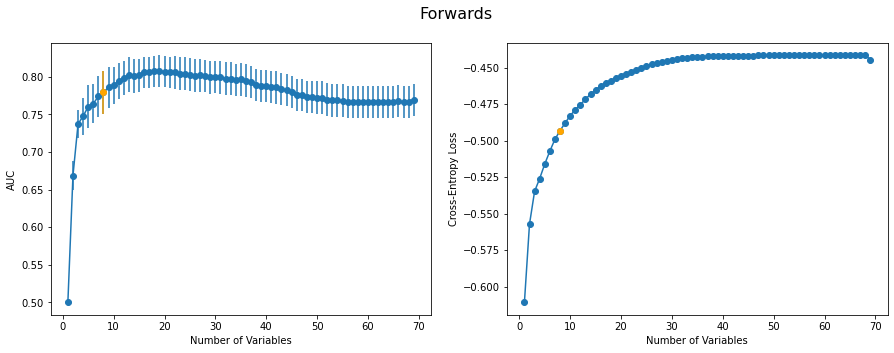


Variable importance within subset (most important -> least important)
---------------------------------------------------------------------

0                                            intercept
1    status_... >= 200 DM / salary for at least 1 year
2                                             duration
3    credit_history_all credits at this bank paid b...
4                                       purpose_others
5           personal_status_sex_male : married/widowed
6                           status_no checking account
7       credit_history_delay in paying off in the past
Name: selected, dtype: object

----------------------------------------------------------------------------------------------------

Backward stepwise selection
---------------------------


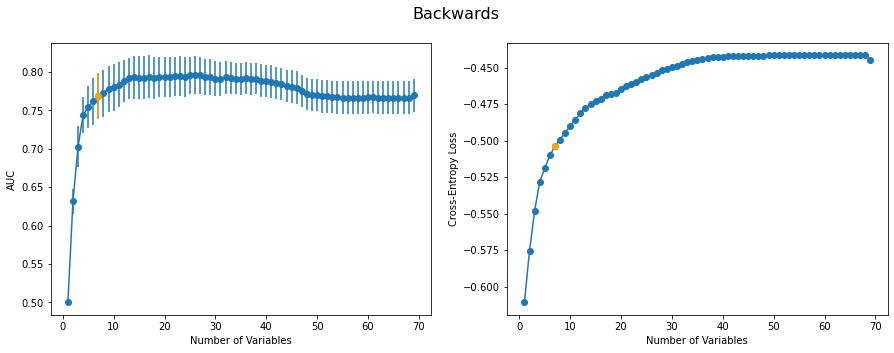


Variable importance within subset (most important -> least important)
---------------------------------------------------------------------

0                                            intercept
1                           status_no checking account
2                                    status_... < 0 DM
3                                             duration
4    credit_history_all credits at this bank paid b...
5                                       purpose_others
Name: discarded, dtype: object


In [12]:
res = subset_selection(clf_lr)
forward_subset = res.forward_subset
backward_subset = res.backward_subset

In [13]:
print(forward_subset)
print(backward_subset)

auc                                                     0.779278
auc_se                                                  0.028919
logloss                                                -0.493219
subset         [intercept, status_... >= 200 DM / salary for ...
selected          credit_history_delay in paying off in the past
subset_size                                                    8
Name: 7, dtype: object
auc                                                     0.768713
auc_se                                                  0.029363
logloss                                                -0.503923
subset         [duration, status_... < 0 DM, status_no checki...
discarded      personal_status_sex_female : non-single or mal...
subset_size                                                    7
Name: 62, dtype: object


In [14]:
# Shared columns between subsets
[col for col in forward_subset['subset'] if col in backward_subset['subset']]

['intercept',
 'duration',
 'credit_history_all credits at this bank paid back duly',
 'purpose_others',
 'status_no checking account']

### Polynomial features

With our subset now selected, we can try some feature transforms for our quantitative column (duration)

In [15]:
def poly_cv(clf):
    poly_df = X_train[:,col_mask(
        [col for col in forward_subset['subset'] if col != 'duration'])].copy()
    
    # Get polynomial features
    duration = np.array(X_train[:,col_mask(['duration'])]).reshape(-1,1)
    duration_square = np.array([d**2 for d in duration]).reshape(-1,1)
    duration_cube = np.array([d**2 for d in duration]).reshape(-1,1)
    
    # Append to original
    poly_df = np.hstack([poly_df,duration,duration_square,duration_cube])
    
    auc_scores = []
    
    # Cross validate
    for train_index, test_index in kf.split(poly_df,y_train):
        X_tr, X_te = poly_df[train_index], poly_df[test_index]
        y_tr, y_te = y_train[train_index], y_train[test_index]
        clf.fit(X_tr,y_tr)
        auc_scores.append(roc_auc_score(y_te,clf.predict_proba(X_te)[:,1]))
            
    return [np.mean(auc_scores), # AUC mean
            np.std(auc_scores)/np.sqrt(len(auc_scores))] # SE of AUC mean

poly_cv(clf_lr)

[0.7805431547619047, 0.026310235547937225]

### Decision thresholding

In [16]:
lr_threshold_obj1, lr_threshold_obj2 = evaluate(clf_lr,
                                                subset=col_mask(forward_subset['subset'])).cv_threshold()


Objective 1 Results
-------------------

   threshold       tnr       tpr
0      0.355  0.857143  0.708333
1      0.500  0.892857  0.416667
2      0.405  0.875000  0.583333
3      0.410  0.857143  0.791667
4      0.480  0.875000  0.375000
5      0.350  0.857143  0.750000
6      0.590  0.857143  0.291667
7      0.495  0.946429  0.625000
8      0.510  0.875000  0.541667
9      0.500  0.875000  0.666667

----------------------------------------------------------------------------------------------------

Objective 2 Results
-------------------

   threshold       tnr  tpr
0      0.045  0.071429  1.0
1      0.035  0.089286  1.0
2      0.105  0.428571  1.0
3      0.075  0.196429  1.0
4      0.000  0.000000  1.0
5      0.100  0.339286  1.0
6      0.050  0.107143  1.0
7      0.125  0.410714  1.0
8      0.095  0.267857  1.0
9      0.055  0.053571  1.0


***
# Final Results

### Tree

In [17]:
final_tree_probs, final_tree = evaluate(DecisionTreeClassifier(**final_tree_params)).model_assessment(
    obj1_threshold=tree_threshold_obj1,
    obj2_threshold=tree_threshold_obj2)


Objective 1 out-of-sample performance
-------------------------------------

TPR: 0.0
TNR: 1.0

----------------------------------------------------------------------------------------------------

Objective 2 out-of-sample performance
-------------------------------------

TPR: 1.0
TNR: 0.0


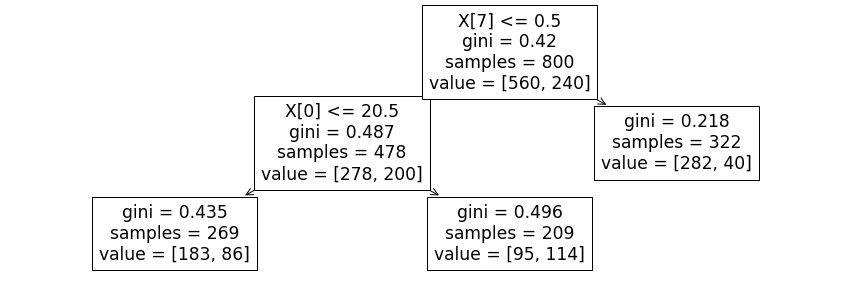

In [18]:
plt.figure(figsize=(15,5))
tree.plot_tree(final_tree)#,feature_names=df.drop(columns=['credit_risk']).columns)
plt.show()

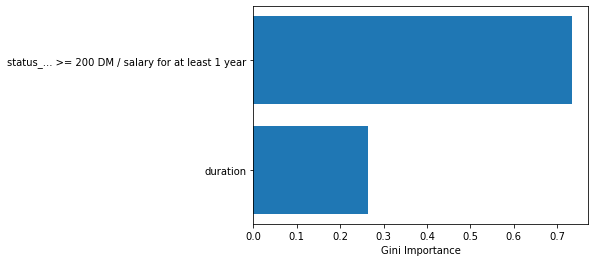

In [19]:
def gini_importance():
    gini_importance = pd.DataFrame({'imp':final_tree.feature_importances_[final_tree.feature_importances_>0],
                                    'col':df.drop(columns=['credit_risk']).columns[final_tree.feature_importances_>0]})
    gini_importance.sort_values(by='imp',inplace=True)
    plt.barh(width=gini_importance.imp,
             y=gini_importance.col)
    plt.xlabel('Gini Importance')
    return plt.show()

gini_importance()

### Logistic Regression

In [20]:
final_lr_probs, final_lr = evaluate(clf_lr,
                                    subset=col_mask(forward_subset['subset'])).model_assessment(
    obj1_threshold=lr_threshold_obj1,
    obj2_threshold=lr_threshold_obj2)


Objective 1 out-of-sample performance
-------------------------------------

TPR: 0.5166666666666667
TNR: 0.7571428571428571

----------------------------------------------------------------------------------------------------

Objective 2 out-of-sample performance
-------------------------------------

TPR: 0.9666666666666667
TNR: 0.1357142857142857


### Comparison

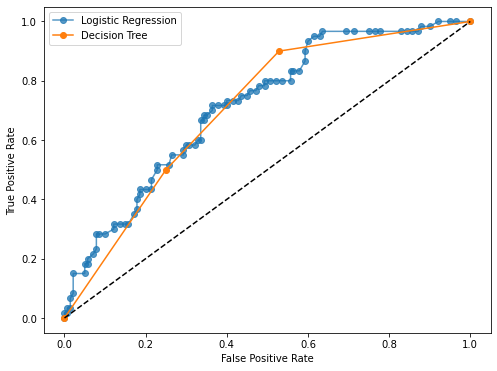

In [21]:
def ROC():
    plt.figure(figsize=(8,6))
    
    # Logistic Regression
    lfpr, ltpr, lthresholds = roc_curve(y_test,final_lr_probs)
    plt.plot(lfpr,ltpr,'-o',label='Logistic Regression',alpha=0.75)

    # Tree
    tfpr, ttpr, tthresholds = roc_curve(y_test,final_tree_probs)
    plt.plot(tfpr,ttpr,'-o',label='Decision Tree')
    
    # Dummy strategy
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    return plt.show()

ROC()

Unique probabilities (displaying that LR is a more continuous method in this case)

In [22]:
print(len(set(final_lr_probs)))
print(len(set(final_tree_probs)))

130
3
